In [7]:
library(MWASTools)

library(MetaboMate)

#Importing data from Github
Metadata <-read.csv('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/Propoleo_metadata.csv', header= TRUE, sep= ";")
dim(Metadata)
head(Metadata)

[1] 123  18

SampleID,SampleNMR,Date_YMD,Probe,Shims,RG,Type,Folder,Origen,Zona,Type3,Type2,Color,R,G,B,Extracto,Resinas..
M46,PRO046B_PRO,190205,2,,64,,32,Santander,bh-PM,0,2,reddish_brown,115,2,0,"5,48",ND
M47,PRO047A_PRO,190205,2,,"50,8",,32,Santander,bh-PM,0,2,reddish_yellow,246,99,1,"4,23",65
M47,PRO047B_PRO,190205,2,,"45,2",,32,Santander,bh-PM,0,2,reddish_yellow,246,99,1,"4,23",65
M48,PRO048A_PRO,190118,2,,"60,5",,32,Casanare,bh-T,0,2,yellow,162,133,54,"7,74",14
M25,PRO025A_PRO,180917,1,,"90,5",,22,Tolima,bh-T,0,2,light_yellow,108,102,68,"3,58",0
M44,PRO044A_C,190206,2,,64,C,22,Brasil,BRA,0,1,red,115,2,0,"11,51",ND


In [8]:
part1 <- read.csv('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/part1d.csv', header= T, sep= ",")
dim(part1)
part2 <- read.csv('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/part2d.csv', header= T, sep= ",")
dim(part2)


[1] 131072     60

[1] 131072     63

In [9]:
X <- cbind(part1, part2)
dim(X)
colnames(X) <- seq_along(X[1,])

[1] 131072    123

In [10]:
ppm <- read.csv('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/ppmpro_all_center.csv', header= FALSE)

a_intensity <- t(X)
ppm <- t(ppm)

dim(a_intensity)
dim(Metadata)
dim(ppm)

[1]    123 131072

[1] 123  18

[1]      1 131072

# Data pre-processing

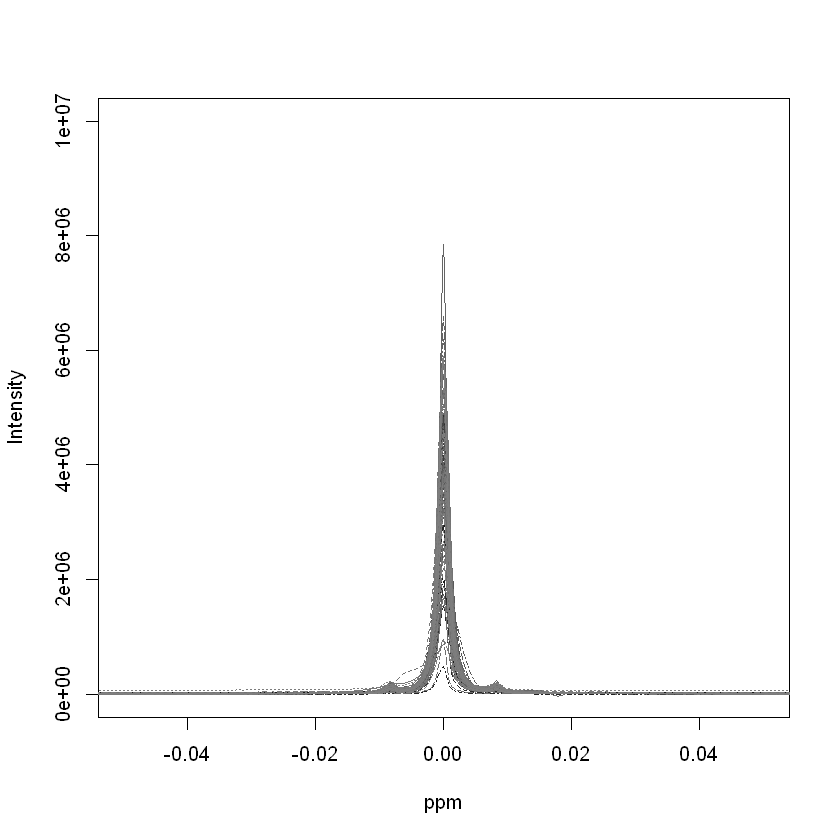

In [11]:
#Bad shimming samples 
X <- a_intensity[c(-22, -25, -33, -36, -104, -112, -113, -119),]#Bad shimming samples
Metadata_f <- Metadata[c(-22, -25, -33, -36, -104, -112, -113, -119),]#Bad shimming samples from metadata

#Spectra Calibration
X.cali=calibration(X, ppm, type='Urine')

#Visualization
Gray <- gray.colors(115, start=0.1, end=0.5, gamma=2.2, alpha=NULL)

matplot(t(ppm),t(X.cali), type=("l"), xlim = c(-0.05,0.05), ylim=c(-1e4, 1e7), xlab="ppm", ylab="Intensity", col=Gray)

#Indexing of chemical shifts regions

idx.TMS= get.idx(range=c(min(ppm),0.5), ppm)
idx.meoh1= get.idx(range=c(3.15,3.29), ppm)
idx.meoh2= get.idx(range=c(3.32,3.38), ppm)
idx.meoh3= get.idx(range=c(3.51,3.54), ppm)
idx.water= get.idx(range=c(4.84,4.94), ppm)
idx.noise= get.idx(range=c(8.5,max(ppm)), ppm)

#Excision of undesired regions

X.cali=X.cali[,-c(idx.TMS, idx.meoh1, idx.meoh2, idx.meoh3, idx.water, idx.noise)]
ppm.ex=ppm[-c(idx.TMS, idx.meoh1, idx.meoh2, idx.meoh3, idx.water, idx.noise)]

#Baseline correction

X.bl=bline(X.cali)


# STOCSY

## All samples

[1]   115 48904

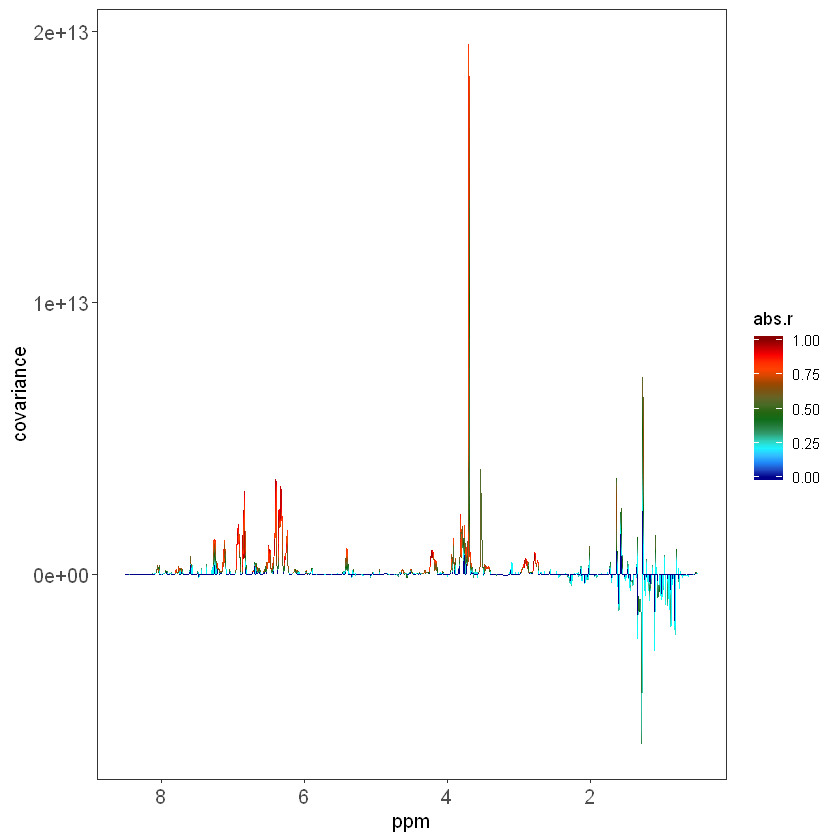

In [12]:
dim(X.bl) #Spectra data matrix
rownames(X.bl) <- Metadata_f$SampleNMR 
colnames(X.bl) <- ppm.ex

metadata <- as.matrix(Metadata_f$Date_YMD) #Must be a numerical matrix
rownames(metadata) <- Metadata_f$SampleNMR
colnames(metadata) <- "Fecha"

SampleType<- Metadata_f$Type3 #Sample type 1:QC ; 0: Experiment

data_SE = MWAS_SummarizedExperiment(X.bl, metadata, SampleType)
stocsy = STOCSY_NMR(data_SE, ppm_query = 6.83)


## Red propolis

[1]    18 48904

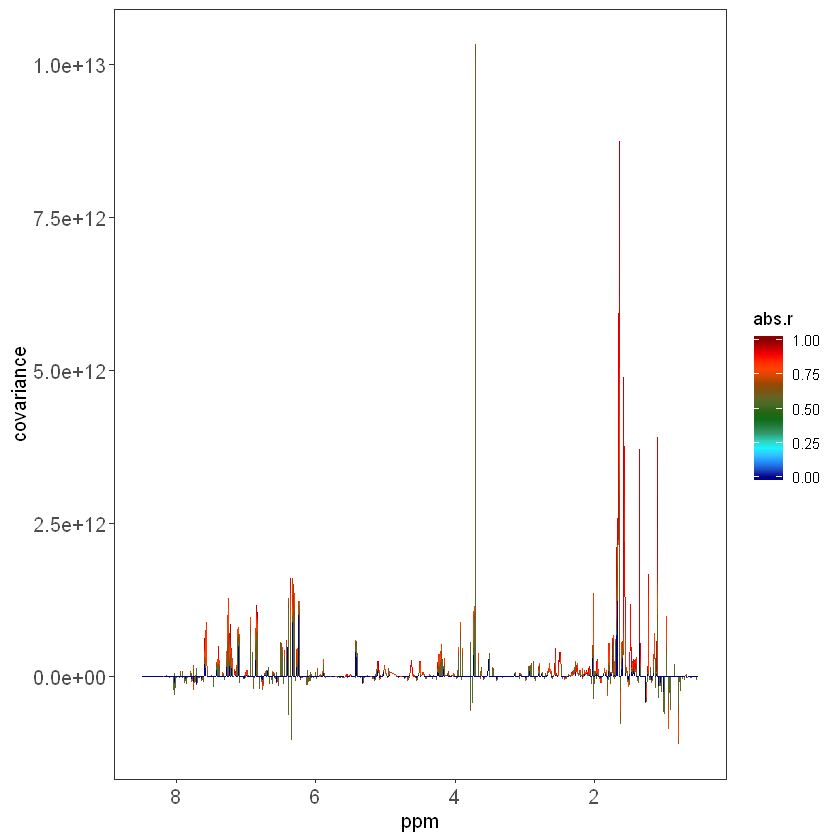

In [13]:
red_propolis <- subset(X, Metadata_f$Color=="red")

red_propolis <- red_propolis[c(-1),]

Metadata_red <- subset(Metadata_f, Metadata_f$Color=="red")

Metadata_red <- Metadata_red[c(-1),]

red_propolis.cali= calibration(red_propolis, ppm, type='Urine')

red_propolis.cali= red_propolis.cali[,-c(idx.TMS, idx.meoh1, idx.meoh2, idx.meoh3, idx.water, idx.noise)]

#Baseline correction

red_propolis.bl= bline(red_propolis.cali)

#Spectral normalisation

red_propolis.pqn= pqn(red_propolis.bl, add.DilF = 'dilF.pqn')
red_propolis.ta= totalArea(red_propolis.bl, add.DilF = 'dilF.ta')

dim(red_propolis.bl) #Spectra data matrix
rownames(red_propolis.bl) <- Metadata_red$SampleNMR 
colnames(red_propolis.bl) <- ppm.ex

metadatared <- as.matrix(Metadata_red$Date_YMD) #Must be a numerical matrix
rownames(metadatared) <- Metadata_red$SampleNMR
colnames(metadatared) <- "Fecha"

SampleTypered<- Metadata_red$Type3 #Sample type 1:QC ; 0: Experiment

data_r = MWAS_SummarizedExperiment(red_propolis.bl, metadatared, SampleTypered)
stocsy = STOCSY_NMR(data_r, ppm_query = 6.83)

